The necessary libraries are installed and modules imported. The segementation models library is chosen since it provides feature extractors with pre-trained weights and a model with U-net architecture which is popularly used for medical image segmentation. The albumentaions library is chosen for image augmentaion since it has functions for augmenting both images and masks for segmentation.

In [2]:
%tensorflow_version 1.x
# !pip install tensorflow
!pip install h5py==2.10.0

!pip install -q pyyaml
!pip install patchify
!pip install segmentation-models
!pip install -U albumentations
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor

# to generate gifs
# !pip install imageio
# !pip install colabcode

# !pip install mpl_interactions[jupyter]


from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
# import tensorflow.data.Dataset as tfds
# import tensorflow_probability as tfp
# from tensorflow.keras.callbacks import ModelCheckpoint
# import tensorflow.keras.layers as tfkl
from skimage.transform import resize
from tensorflow import keras
import segmentation_models as sm
sm.set_framework('tf.keras')
# from segmentation_models.utils import set_trainable
# sm.set_framework('tf.keras')

import albumentations as alb

# from ImageDataAugmentor.image_data_augmentor import *

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from patchify import patchify
import tifffile as tiff
from functools import partial
import pathlib
import random
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw
import imageio, cv2

# from IPython import display
# import colabcode as cc
# tfds = tf.data.Dataset

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 8.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 102 kB 9.6 MB/s 
     |████████████████████████████████| 47.6 MB 121 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
sm.set_framework('tf.keras')

Data is loaded.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
data_root = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Wood Anomaly')

image_paths = list(data_root.glob('*'))
image_paths

[PosixPath('/content/drive/My Drive/Colab Notebooks/Wood Anomaly/masks.tif'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Wood Anomaly/dataG.tif'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Wood Anomaly/labeled.tif'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Wood Anomaly/masksOnly.tif')]

Some of the anomalies in the images are annotated using Apeer and the resulting binary masks are saved. The RGB images are converted to grayscale.

In [6]:
large_image_stack = tiff.imread(str(image_paths[1]))

large_mask_stack = tiff.imread(str(image_paths[3]))

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

Since number of images is very small, one image is reservd for the test set while the others are used for training. All images are divided into non-overlapping square patches of size 256*256.

In [7]:
steps = 256

w = int(round(large_image_stack.shape[1]/steps))*steps
h = int(round(large_image_stack.shape[2]/steps))*steps

trainSize = int(360*4)

def Patch_Images(large_image_stack, large_mask_stack):

  all_img_patches = []
  for img in range(large_image_stack.shape[0]):
      
      large_image = large_image_stack[img]
      
      resized_image = resize(large_image, (w, h), anti_aliasing=True)

      patches_img = patchify(resized_image, (steps, steps), step=steps)

      for i in range(patches_img.shape[0]):
          for j in range(patches_img.shape[1]):
              
              single_patch_img = patches_img[i,j,:,:]
              single_patch_img = (single_patch_img.astype('float32')) / 255.
                    
              all_img_patches.append(single_patch_img)

  images = np.array(all_img_patches)


  all_mask_patches = []
  for img in range(large_mask_stack.shape[0]):
      
      large_mask = large_mask_stack[img]

      resized_mask = resize(large_mask, (w, h), anti_aliasing=True)
      
      patches_mask = patchify(resized_mask, (steps, steps), step=steps) 
      
      for i in range(patches_mask.shape[0]):
          for j in range(patches_mask.shape[1]):
              
              single_patch_mask = patches_mask[i,j,:,:]
              single_patch_mask = single_patch_mask / 255.
              
              all_mask_patches.append(single_patch_mask)

  masks = np.array(all_mask_patches)

  return images, masks


In [8]:
train_patched = Patch_Images(large_image_stack[:-1], large_mask_stack[:-1])
test_patched = Patch_Images(np.expand_dims(large_image_stack[-1], 0), np.expand_dims(large_mask_stack[-1], 0))

In [8]:
train_patched[0].shape

(400, 256, 256)

Data Augmentation is used to increase the size of the dataset. Both the image and mask patches are  either flipped vertically, horizontally or transposed. Each resulting image is saved while another copy is saved after being subjected to a random rotation and a gaussian blur filter. 2 extra channels are added to the grayscale images since segmentation models library requires 3 channels in the input dimension.


In [9]:

def Augment_Images(images, masks):  

  new_image_stack = images.copy()
  new_mask_stack = masks.copy()

  for img in range(images.shape[0]):
    image = images[img]
    mask = masks[img]

    transform1 = alb.VerticalFlip(p=1)  
    transform2 = alb.HorizontalFlip(p=1)
    transform3 = alb.Transpose(p=1)
    transform4 = alb.RandomRotate90(p=1)
    transform5 = alb.GaussianBlur(p=1)

    augmented_image1 = transform1(image=image, mask=mask)
    augmented_image2 = transform2(image=image, mask=mask)
    augmented_image3 = transform3(image=image, mask=mask)

    augmented_image14 = transform4(image=augmented_image1['image'], mask=augmented_image1['mask'])
    augmented_image145 = transform5(image=augmented_image14['image'], mask=augmented_image14['mask'])
    augmented_image24 = transform4(image=augmented_image2['image'], mask=augmented_image2['mask'])
    augmented_image245 = transform5(image=augmented_image24['image'], mask=augmented_image24['mask'])
    augmented_image34 = transform4(image=augmented_image3['image'], mask=augmented_image3['mask'])
    augmented_image345 = transform5(image=augmented_image34['image'], mask=augmented_image34['mask'])

    aug_image_stack = np.stack((augmented_image1['image'], augmented_image2['image'], augmented_image3['image'], 
                                augmented_image145['image'], augmented_image245['image'], augmented_image345['image']), 0)

    new_image_stack = np.concatenate((new_image_stack, aug_image_stack), axis=0)

    aug_mask_stack = np.stack((augmented_image1['mask'], augmented_image2['mask'], augmented_image3['mask'],
                               augmented_image145['mask'], augmented_image245['mask'], augmented_image345['mask']), 0)
    
    new_mask_stack = np.concatenate((new_mask_stack, aug_mask_stack), axis=0)

  return np.stack((new_image_stack,)*3, axis=-1), np.expand_dims(new_mask_stack, -1)

In [10]:
train_augmented = Augment_Images(train_patched[0], train_patched[1])
test_augmented = Augment_Images(test_patched[0], test_patched[1])

In [11]:
print(train_augmented[0].shape)
print(test_augmented[0].shape)

(2800, 256, 256, 3)
(560, 256, 256, 3)


1332


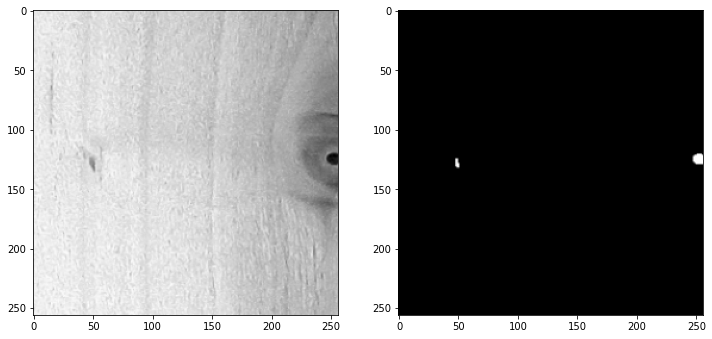

In [14]:
#Sanity check, view few images
startNum = 0
image_number = random.randint(startNum, len(train_augmented[0])-1)  # 338, 293, 157, 
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_augmented[0][image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(train_augmented[1][image_number, :,:, 0], cmap='gray')
# plt.imshow(np.reshape(y_train[image_number], (steps, steps)), cmap='gray')
plt.show()

The 'mobilenetv2' architecture is chosen as the backbone for the encoder and decoder branches of the U-net since it has low number of parameters and hence easier to train on limited resources.

In [15]:
# Define the model

BACKBONE = 'mobilenetv2'

preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
images1=preprocess_input1(train_augmented[0])
images2=preprocess_input1(test_augmented[0])
print(images1.shape)

(2800, 256, 256, 3)


The train and test sets are defined.

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(images1, train_augmented[1], test_size = 0.2, random_state = 42)

X_train, y_train, X_test, y_test = images1, train_augmented[1], images2, test_augmented[1]

1803


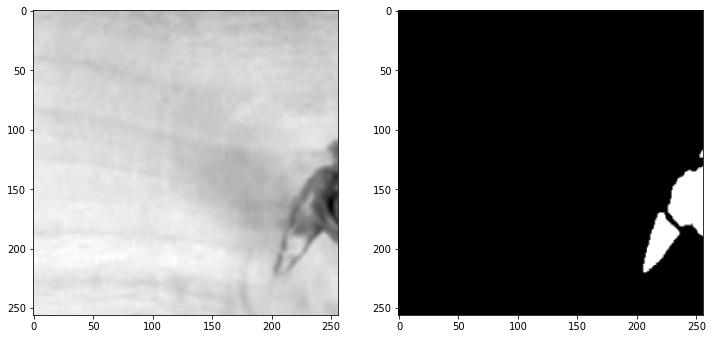

In [17]:
#Sanity check, view few images
image_number = random.randint(0, len(X_train)-1)  # 338, 293, 157, 
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number, :,:, 0], cmap='gray')
# plt.imshow(np.reshape(y_train[image_number], (steps, steps)), cmap='gray')
plt.show()

A function from the segmentation model is redefined since there was an error in the default code.

In [18]:
def set_trainable(model, recompile=True, **kwargs):
    """Set all layers of model trainable and recompile it
    Note:
        Model is recompiled using same optimizer, loss and metrics::
            model.compile(
                model.optimizer,
                loss=model.loss,
                metrics=model.metrics,
                loss_weights=model.loss_weights,
                sample_weight_mode=model.sample_weight_mode,
                weighted_metrics=model.weighted_metrics,
            )
    Args:
        model (``keras.models.Model``): instance of keras model
    """
    for layer in model.layers:
        layer.trainable = True

    if recompile:
        model.compile(
            model.optimizer,
            loss=model.loss,
            metrics=model.metrics,
            loss_weights=model.loss_weights,
            sample_weight_mode=model.sample_weight_mode,
            # weighted_metrics=model.weighted_metrics,
        )

The loss function is chosen as the jaccard loss which is effective for pixel segmentaion.

In [19]:
lossF = sm.losses.bce_jaccard_loss

The model is compiled with pretrained weights obtained from training with the 'imagenet' dataset and trained.

In [20]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True,) # decoder_use_batchnorm=True)
model.compile('Adam', loss=lossF, metrics=[sm.metrics.iou_score])
# print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/tensorflow-1.15.2/python3.7/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Initially training is carried out for a few epochs by freezing the encoder branch, after which the entire model is trained. The initial fine-tuning is carried out to avoid large changes in the endoder weights due to large gradients.

In [ ]:
#Fit the model
model.fit(X_train, y_train, validation_split=0.1, epochs=3)
set_trainable(model)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100)

Train on 2520 samples, validate on 280 samples
Epoch 1/3
  64/2520 [..............................] - ETA: 51:44 - loss: 1.5865 - iou_score: 1.6554e-05

The results are of poor quality and the iou score is very low. This is due to the low number of masks in the trainig data.

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(images2)
y_pred_thresholded = test_augmented[1] > 0.5

intersection = np.logical_and(test_augmented[1], y_pred_thresholded)
union = np.logical_or(test_augmented[1], y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.2322794390554527


In [ ]:
test_img_number = random.randint(0, len(images2)-1)
test_img_number = 32
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()